In [0]:
%matplotlib inline
import pandas as pd


<img src="https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/header.png" alt="drawing"/>


A multi-channel electroencephalography (EEG) system enables a broad range of applications including neurotherapy, biofeedback, and brain computer interfacing. The dataset you will analyse is created with the [Emotiv EPOC+](https://www.emotiv.com/product/emotiv-epoc-14-channel-mobile-eeg).  

It has 14 EEG channels with names based on the International 10-20 locations: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4:

<br/>
<br/>
<center>
<img src="https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/EEG.png" alt="drawing" width="200"/>
<center/>
<br/>
<br/>


All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. 

The experiment was conducted on one person only. The duration of the measurement was around 117 seconds.

From the paper:

> *The experiment was carried out in a quiet room. During
the experiment, the proband was being videotaped. To prevent
artifacts, the proband was not aware of the exact start time
of the measurement. Instead, he was told to sit relaxed, look
straight to the camera, and change the eye state at free will.
Only additional constraint was that, accumulated over the
entire session, the duration of both eye states should be about
the same and that the individual intervals should vary greatly
in length (from eye blinking to longer stretches)...*

The eye state was detected via a camera during the EEG measurement and later added manually to the file after analyzing the video frames. 

A label '1' indicates the eye-closed and '0' the eye-open state.

(*Source: Oliver Roesler, Stuttgart, Germany*)

Let's load the train and test set:

In [0]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")

testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

sample_submission = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/sample_submission.csv")


You will fit a model on the trainset and make predictions on the testset. 

To submit these predictions to Kaggle you need to write a .csv file with two columns: 
- `index` that matches the `index` column in the test set.
- `label` which is your prediction.

Here is an example predictions file for Kaggle:

In [35]:
trainset.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,label
0,4299.49,3997.44,4277.95,4116.92,4353.85,4623.08,4100.00,4623.59,4202.56,4229.23,4211.79,4278.97,4600.00,4369.23,1
1,4302.05,3985.64,4261.03,4129.74,4334.36,4615.38,4072.31,4585.64,4192.31,4225.13,4195.90,4283.08,4607.18,4358.46,0
2,4321.03,4015.90,4265.13,4122.56,4333.33,4613.33,4072.82,4602.05,4192.31,4223.08,4155.38,4286.15,4608.21,4371.79,0
3,4408.21,4104.10,4380.00,4232.31,4449.74,4750.26,4169.23,4731.28,4311.28,4352.31,4319.49,4388.21,4715.90,4464.10,0
4,4347.18,3975.38,4266.67,4102.56,4333.33,4617.95,4097.44,4612.82,4210.77,4240.51,4248.21,4313.33,4664.10,4411.79,1


In [36]:
testset.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,index
0,4296.41,4040.51,4253.33,4124.10,4341.54,4618.46,4075.38,4601.03,4183.59,4204.10,4197.44,4268.72,4598.46,4342.56,0
1,4291.28,3994.36,4247.18,4102.56,4328.21,4616.41,4057.44,4622.56,4198.46,4227.69,4190.77,4260.51,4593.33,4337.95,1
2,4299.49,4019.49,4269.74,4116.41,4344.10,4635.38,4067.18,4627.18,4211.28,4233.33,4202.56,4280.51,4596.92,4350.26,2
3,4280.00,4004.62,4263.59,4120.51,4323.59,4603.08,4040.51,4589.23,4174.87,4212.82,4192.82,4271.79,4608.72,4344.10,3
4,4317.44,3968.72,4260.51,4101.54,4341.54,4600.51,4071.28,4607.69,4191.28,4231.28,4199.49,4282.05,4592.31,4372.82,4


In [5]:
sample_submission.head(10)

,index,label
0,0,0.168801
1,1,0.124169
2,2,0.947757
3,3,0.069585
4,4,0.635325
5,5,0.659027
6,6,0.653697
7,7,0.850030
8,8,0.160489
9,9,0.843272


Make sure to save your results without the extra Pandas index column that is written by default:

In [0]:
filename = "my_prediction_results.csv"

#make sure to not write the Pandas index column (index=False)
sample_submission.to_csv(filename,index=False)

Notice that this predictions file is saved on the cloud server machine. To download this file to your local machine you need to click the "Files" icon that you find in the sidebar on the left.

Submit this file to the [Kaggle competition website](https://www.kaggle.com/t/09885716fbf14eb08cc1cee2c9ebe7cc) to get an evaluation of your predictions on the public leaderboard.

For the report I want you to write a notebook with a scientific description of your analysis. You have to compare the prediction performance of your two best prediction models. This includes data pre-processing, hyperparameter tuning and model evaluation. I also want you to compare the actual predictions made by each model.

To create a new notebook go the "File" in the menu bar and click "New notebook". Do not forget to save your notebook to your GitHub account. You can create as many notebook as you want, but the final report should be in a notebook with the name "Kaggle_eye_blinking_prediciton.ipynb"

You will be evaluated (equal points) on clarity of the report, scientific insight and complexity of the analysis. 

In [0]:
trainset_copy = trainset.copy()
label_column = trainset.pop('label')


In [38]:
trainset.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
0,4299.49,3997.44,4277.95,4116.92,4353.85,4623.08,4100.00,4623.59,4202.56,4229.23,4211.79,4278.97,4600.00,4369.23
1,4302.05,3985.64,4261.03,4129.74,4334.36,4615.38,4072.31,4585.64,4192.31,4225.13,4195.90,4283.08,4607.18,4358.46
2,4321.03,4015.90,4265.13,4122.56,4333.33,4613.33,4072.82,4602.05,4192.31,4223.08,4155.38,4286.15,4608.21,4371.79
3,4408.21,4104.10,4380.00,4232.31,4449.74,4750.26,4169.23,4731.28,4311.28,4352.31,4319.49,4388.21,4715.90,4464.10
4,4347.18,3975.38,4266.67,4102.56,4333.33,4617.95,4097.44,4612.82,4210.77,4240.51,4248.21,4313.33,4664.10,4411.79


In [39]:
#1.Start of by weighing all features at the same scale
from sklearn.preprocessing import StandardScaler

trainset_unscaled_cols = trainset.columns.values
scaler = StandardScaler()
scaler.fit(trainset)
trainset_stand = pd.DataFrame(scaler.transform(trainset),columns=trainset_unscaled_cols)

trainset_stand.head() # standardized features except label column

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
0,-0.018351,-0.396476,0.677912,-0.277047,0.733699,0.167400,1.330668,0.454721,0.093570,-0.068336,0.418469,0.026714,-0.156365,0.252992
1,0.052070,-0.791842,-0.136210,0.346482,-0.434286,-0.259658,0.007585,-1.609301,-0.482085,-0.276922,-0.232997,0.235973,0.060820,-0.037576
2,0.574178,0.222036,0.061066,-0.002733,-0.496011,-0.373355,0.031954,-0.716795,-0.482085,-0.381214,-1.894254,0.392280,0.091976,0.322059
3,2.972354,3.177226,5.588146,5.335202,6.480134,7.221060,4.638614,6.311759,6.199439,6.193291,4.834001,5.588622,3.349453,2.812530
4,1.293521,-1.135609,0.135164,-0.975478,-0.496011,-0.117120,1.208346,-0.131037,0.554655,0.505527,1.911632,1.776139,1.782573,1.401236


In [40]:
trainset_stand.head()

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
0,-0.018351,-0.396476,0.677912,-0.277047,0.733699,0.167400,1.330668,0.454721,0.093570,-0.068336,0.418469,0.026714,-0.156365,0.252992
1,0.052070,-0.791842,-0.136210,0.346482,-0.434286,-0.259658,0.007585,-1.609301,-0.482085,-0.276922,-0.232997,0.235973,0.060820,-0.037576
2,0.574178,0.222036,0.061066,-0.002733,-0.496011,-0.373355,0.031954,-0.716795,-0.482085,-0.381214,-1.894254,0.392280,0.091976,0.322059
3,2.972354,3.177226,5.588146,5.335202,6.480134,7.221060,4.638614,6.311759,6.199439,6.193291,4.834001,5.588622,3.349453,2.812530
4,1.293521,-1.135609,0.135164,-0.975478,-0.496011,-0.117120,1.208346,-0.131037,0.554655,0.505527,1.911632,1.776139,1.782573,1.401236


In [41]:
trainset_copy.head() # original trainset data

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,label
0,4299.49,3997.44,4277.95,4116.92,4353.85,4623.08,4100.00,4623.59,4202.56,4229.23,4211.79,4278.97,4600.00,4369.23,1
1,4302.05,3985.64,4261.03,4129.74,4334.36,4615.38,4072.31,4585.64,4192.31,4225.13,4195.90,4283.08,4607.18,4358.46,0
2,4321.03,4015.90,4265.13,4122.56,4333.33,4613.33,4072.82,4602.05,4192.31,4223.08,4155.38,4286.15,4608.21,4371.79,0
3,4408.21,4104.10,4380.00,4232.31,4449.74,4750.26,4169.23,4731.28,4311.28,4352.31,4319.49,4388.21,4715.90,4464.10,0
4,4347.18,3975.38,4266.67,4102.56,4333.33,4617.95,4097.44,4612.82,4210.77,4240.51,4248.21,4313.33,4664.10,4411.79,1


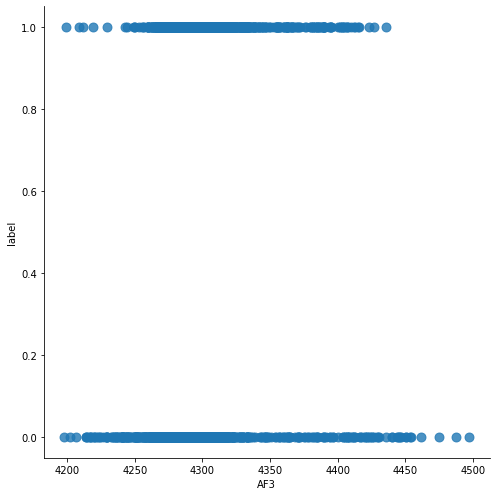

In [49]:
from sklearn import metrics
import seaborn as sns;
import matplotlib.pyplot as plt;

sns.lmplot(x='AF3', y='label', data= trainset_copy, fit_reg=False, height=7, scatter_kws={"s": 80})
plt.show() # We need a logistic regression model

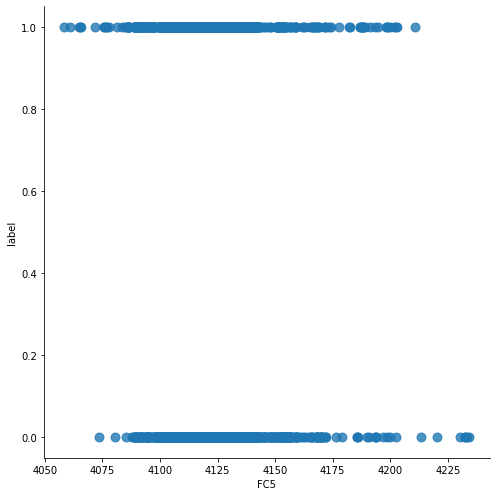

In [50]:
sns.lmplot(x='FC5', y='label', data= trainset_copy, fit_reg=False, height=7, scatter_kws={"s": 80})
plt.show()

In [42]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
import numpy as np

model = LogisticRegression(C= 0.1)
scores = cross_val_score(model,trainset_stand, y=trainset_copy['label'], cv=10)

print(np.mean(scores))



0.6195
